# Importing libraries

In [ ]:
%%capture
!pip install Lime
!pip install nrclex

In [ ]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

nltk.download("stopwords")
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()
nltk.download('punkt')

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn import metrics
from nrclex import NRCLex
import time
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Import necessary libraries
import time


#Lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Loead cleaned dataset
clean_dataset = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRWr_MjsHPJuBNPxa6O8Bv08WFS_AhGPwFwzYSBrQkuDwEpZiq7kaYeCT7bXpZ0trCCYe-oiwJXvQSg/pub?gid=1379447240&single=true&output=csv'


In [ ]:
keep_labels = ['post', 'subreddit']
dataset = pd.read_csv(clean_dataset)
#reduced_data = dataset.sample(n=10000, random_state=0)
df = dataset[keep_labels]

In [ ]:
df.head(5)

post   subreddit
0  medication help hobby jump curious help stick ...        ADHD
1  still depress lazy year long depressive episod...  Depression
2  something use get thing really bad executive d...        ADHD
3  dae pick lip point raw bleeding cw blood lippi...         BPD
4  not actually use brain like try remember somet...        ADHD

In [ ]:
# Split data into train and test

X = df['post']
y = df['subreddit']


# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling with Text feature

**Creating a pipline using tf-idf for words embedding and different models.**


In [ ]:
#Create a pipeline for model and vectorization

def train_model(model, data, targets):
    """
    Train a model on the given data and targets.

    Parameters:
    model (sklearn model): The model to be trained.
    data (list of str): The input data.
    targets (list of str): The targets.

    Returns:
    Pipeline: The trained model as a Pipeline object.
    """
    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect', TfidfVectorizer()),
                         ('clf', model)])
    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

In [ ]:
def get_F1(trained_model,X,y):
    """
    Get the F1 score for the given model on the given data and targets.

    Parameters:
    trained_model (sklearn model): The trained model.
    X (list of str): The input data.
    y (list of str): The targets.

    Returns:
    array: The F1 score for each class.
    """
    # Make predictions on the input data using the trained model
    predicted=trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1=f1_score(y,predicted, average=None)
    # Return the F1 score
    return f1

**Training the Logistic Regression model on the Training set**


Accuracy:  0.8360867320598864
Precision:  0.8407328808819081
Recall:  0.8360867320598864
F1-Score:  0.8339459490995954


<Figure size 2000x1600 with 0 Axes>

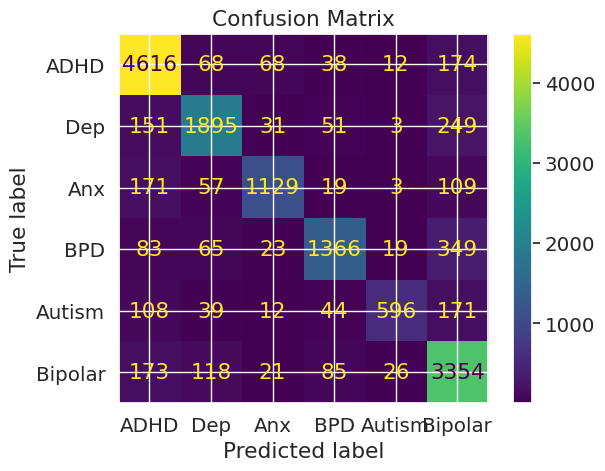

              precision    recall  f1-score   support

        ADHD       0.87      0.93      0.90      4976
     Anxiety       0.85      0.80      0.82      2380
      Autism       0.88      0.76      0.81      1488
         BPD       0.85      0.72      0.78      1905
     Bipolar       0.90      0.61      0.73       970
  Depression       0.76      0.89      0.82      3777

    accuracy                           0.84     15496
   macro avg       0.85      0.78      0.81     15496
weighted avg       0.84      0.84      0.83     15496



In [ ]:
#Train the model with the training data
LR = train_model(LogisticRegression(solver='liblinear', random_state = 0), X_train, y_train)

#test the model with the test data
y_pred = LR.predict(X_test)

#calculate the accuracy
LR_accuracy = accuracy_score(y_test, y_pred)
LR_f1score = f1_score(y_test, y_pred, average='weighted')
LR_precision = precision_score(y_test, y_pred, average='weighted')
LR_recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy: ', LR_accuracy)
print('Precision: ', LR_precision)
print('Recall: ', LR_recall)
print('F1-Score: ', LR_f1score)

class_labels = ['ADHD', 'Dep', 'Anx', 'BPD', 'Autism', 'Bipolar']

# Calculate confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 16))
# Plot the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot()
plt.title("Confusion Matrix")
plt.show()

#calculate the F1 score
f1_Score = get_F1(LR, X_test, y_test)
pd.DataFrame(f1_Score, index=df.subreddit.unique(), columns=['F1 score'])

#Classification Report
print(classification_report(y_test, y_pred))

**Training the Random Forest model on the Training set**

Accuracy:  0.7422560660815695
Precision:  0.7824642386211487
Recall:  0.7422560660815695
F1-Score:  0.7286551354262644


<Figure size 2000x1600 with 0 Axes>

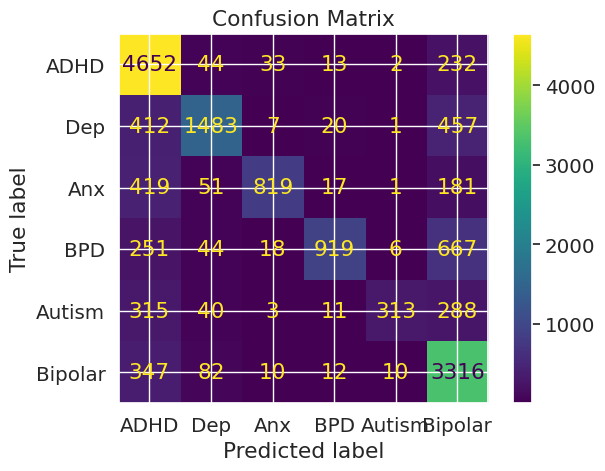

              precision    recall  f1-score   support

        ADHD       0.73      0.93      0.82      4976
     Anxiety       0.85      0.62      0.72      2380
      Autism       0.92      0.55      0.69      1488
         BPD       0.93      0.48      0.63      1905
     Bipolar       0.94      0.32      0.48       970
  Depression       0.65      0.88      0.74      3777

    accuracy                           0.74     15496
   macro avg       0.83      0.63      0.68     15496
weighted avg       0.78      0.74      0.73     15496



In [ ]:
#Train the model with the training data
RF = train_model(RandomForestClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=RF.predict(X_test)

#calculate the accuracy
RF_accuracy = accuracy_score(y_test, y_pred)
RF_f1score = f1_score(y_test, y_pred, average='weighted')
RF_precision = precision_score(y_test, y_pred, average='weighted')
RF_recall = recall_score(y_test, y_pred, average='weighted')


print('Accuracy: ', RF_accuracy)
print('Precision: ', RF_precision)
print('Recall: ', RF_recall)
print('F1-Score: ', RF_f1score)

class_labels = ['ADHD', 'Dep', 'Anx', 'BPD', 'Autism', 'Bipolar']

# Calculate confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 16))
# Plot the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot()
plt.title("Confusion Matrix")
plt.show()

#calculate the F1 score
f1_Score = get_F1(RF, X_test, y_test)
pd.DataFrame(f1_Score, index=df.subreddit.unique(), columns=['F1 score'])

#Classification Report
print(classification_report(y_test, y_pred))


**Training the Support Vector Machine model on the Training set**


Accuracy:  0.8305369127516778
Precision:  0.8355152833654629
Recall:  0.8305369127516778
F1-Score:  0.8285045318695916


<Figure size 2000x1600 with 0 Axes>

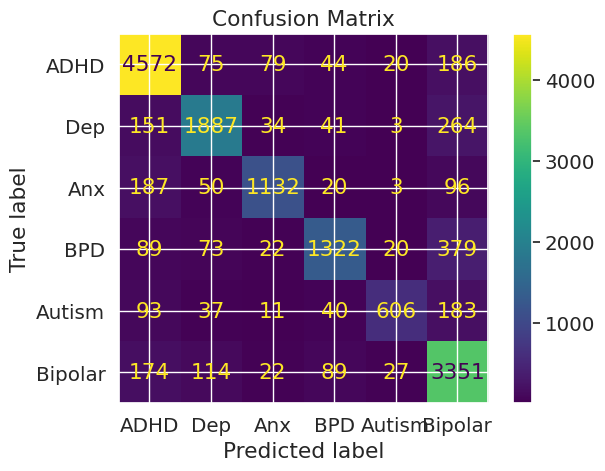

              precision    recall  f1-score   support

        ADHD       0.87      0.92      0.89      4976
     Anxiety       0.84      0.79      0.82      2380
      Autism       0.87      0.76      0.81      1488
         BPD       0.85      0.69      0.76      1905
     Bipolar       0.89      0.62      0.73       970
  Depression       0.75      0.89      0.81      3777

    accuracy                           0.83     15496
   macro avg       0.85      0.78      0.81     15496
weighted avg       0.84      0.83      0.83     15496



In [ ]:
#Train the model with the training data
SVM = train_model(SVC(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=SVM.predict(X_test)

#calculate the accuracy
SVM_accuracy = accuracy_score(y_test, y_pred)
SVM_f1score = f1_score(y_test, y_pred, average='weighted')
SVM_precision = precision_score(y_test, y_pred, average='weighted')
SVM_recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy: ', SVM_accuracy)
print('Precision: ', SVM_precision)
print('Recall: ', SVM_recall)
print('F1-Score: ', SVM_f1score)

class_labels = ['ADHD', 'Dep', 'Anx', 'BPD', 'Autism', 'Bipolar']

# Calculate confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 16))
# Plot the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot()
plt.title("Confusion Matrix")
plt.show()

#calculate the F1 score
f1_Score = get_F1(SVM, X_test, y_test)
pd.DataFrame(f1_Score, index=df.subreddit.unique(), columns=['F1 score'])

#Classification Report
print(classification_report(y_test, y_pred))

**Results - Text Features**

In [ ]:
# Create a DataFrame with model names, accuracy, and F1-score
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machine', 'Random Forest'],
    'Accuracy': [LR_accuracy.round(3), SVM_accuracy.round(3), RF_accuracy.round(3)],
    'Precision': [LR_precision.round(3), SVM_precision.round(3), RF_precision.round(3)],
    'Recall': [LR_recall.round(3), SVM_recall.round(3), RF_recall.round(3)],
    'F1-Score': [LR_f1score.round(3), SVM_f1score.round(3), RF_f1score.round(3)]
})

# Sort the DataFrame by accuracy in descending order
sorted_models = models.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame
print(sorted_models)


                    Model  Accuracy  Precision  Recall  F1-Score
0     Logistic Regression     0.836      0.841   0.836     0.834
1  Support Vector Machine     0.831      0.836   0.831     0.829
2           Random Forest     0.742      0.782   0.742     0.729


**Lime**



In [ ]:
#c_LR = make_pipeline(tfidf, clf)
explainer_LR = LimeTextExplainer(class_names=LR.classes_)
idx  = 5896
print("Actual Text : ", X[idx])
print("Prediction : ", LR.predict(X)[idx])
print("Actual :     ", y[idx])
exp = explainer_LR.explain_instance(X[idx], LR.predict_proba,top_labels=5)
exp.show_in_notebook()

Actual Text :  protip people adhd spend lot time teamszoom call work quick background male mis diagnose adhd three year ago relatively snr work manage team member three different time zone spend minimum four hour day video call hi like lot we work home year unlikely back office year not always easy keep symptom check especially focus blurting comment thing work even small meeting we try mute mic stop blurt speak give team space talk give second two collect thought speak keep camera look much detail colleague face way moderate control expression movement look mirror webcam look directly colleague speak find easy concentrate relate say hang everyone great
Prediction :  ADHD
Actual :      ADHD


In [ ]:
#c_LR = make_pipeline(tfidf, clf)
explainer_LR = LimeTextExplainer(class_names=LR.classes_)
idx  = 2118
print("Actual Text : ", X[idx])
print("Prediction : ", LR.predict(X)[idx])
print("Actual :     ", y[idx])
exp = explainer_LR.explain_instance(X[idx], LR.predict_proba,top_labels=5)
exp.show_in_notebook()

Actual Text :  anxiety make stupid put committee work hell horrible time anxious participate adequately not appear stupid uninformed topic effectively stupid not think straight not think fast enough respond realtime discussion not process people say not follow discussion not understand heck talk relevant much mental process consume anxiety high brain function like understand moderately complex concept make decision assess analyze justnot available drool idiot practically fight flight mode get month other experience appear stupid literally anxious think straight
Prediction :  Anxiety
Actual :      Anxiety


In [ ]:
#c_LR = make_pipeline(tfidf, clf)
explainer_LR = LimeTextExplainer(class_names=LR.classes_)
idx  = 504
print("Actual Text : ", X_test[idx])
print("Prediction : ", LR.predict(X_test)[idx])
print("Actual :     ", y_test[idx])
exp = explainer_LR.explain_instance(X_test[idx], LR.predict_proba,top_labels=5)
exp.show_in_notebook()

Actual Text :  disable severely depressed hi name jake battle depression anxiety ptsd ever since accident not sure start life horrible start not seem escape bad luck life well work gas station alone night two man come rob store young train go outside get plate number big mistake life see hop car saw remember shout drive car straight run ground confuse look leg mangle backwards bent half bleeding everywhere end severely shatter tibia fibula compound fracture long recovery never knee permanently damage not feel half leg foot ankle accident rode bmx work car active lose everything since two week leave hospital car steal bed ride thing turn ugly ex girlfriend month physical therapy take care enough kick go live mom else speak mom severe bipolar induce psychosis episode year hard move back mom begin isolate self develop severe mental illness every time go outside panic people rob find kill break cold sweat not breathe car pass happen knee destroy not even take care use cane walk feel like l

# **Hyperparameter Tuning**

In [ ]:
# Preprocessing text features with TFIDF and splitting

text_vectorizer = TfidfVectorizer(max_features=2000)  # Using TF-IDF for text vectorization
X_matrix = text_vectorizer.fit_transform(X)
X_df = pd.DataFrame(X_matrix.toarray(), columns=text_vectorizer.get_feature_names_out())

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

In [43]:
# Define hyperparameter search space

param_dist = {'C': np.logspace(-4, 4, 20),  # Regularization parameter
              'penalty': ['l1', 'l2'],  # Regularization type
              'solver': ['liblinear']}   # Solver for logistic regression

param_grid = {'C': np.logspace(-4, 4, 20),
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear']}

# Initialize a Logistic Regression classifier
LR = LogisticRegression(random_state=0)

# RandomizedSearchCV Hyperparameter tuning
start_rs = time.time()
LR_rs = RandomizedSearchCV(estimator=LR, param_distributions=param_dist, n_iter=10, cv=10, random_state=0)
LR_rs.fit(X_train, y_train)
rs_best_params = LR_rs.best_params_
end_rs = time.time()
print("Random Search Time taken:", end_rs - start_rs, "seconds")

# GridSearchCV Hyperparameter tuning
start_gs = time.time()
LR_gs = GridSearchCV(estimator=LR, param_grid=param_grid, cv=10)
LR_gs.fit(X_train, y_train)
gs_best_params = LR_gs.best_params_
end_gs = time.time()
print("Grid Search Time taken:", end_gs - start_gs, "seconds")


Random Search Time taken: 1040.4329013824463 seconds
Grid Search Time taken: 5745.574318408966 seconds


In [44]:
# Model with hypertuning parameters

def tuned_model(best_param, X, y):

    text_vectorizer = TfidfVectorizer(max_features=2000)  # Using TF-IDF for text vectorization
    X_matrix = text_vectorizer.fit_transform(X)
    X_df = pd.DataFrame(X_matrix.toarray(), columns=text_vectorizer.get_feature_names_out())
# Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=1)

    LR = LogisticRegression(**best_param, random_state=0)
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Print the classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)

    # Print the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

In [45]:
print('Logistic Regression with Random Search Tuning')
print('-----------------------------------------')
accuracy = tuned_model(rs_best_params, X, y)
print("Accuracy:", accuracy)

Logistic Regression with Random Search Tuning
-----------------------------------------
Accuracy: 0.8358931337119256
Classification Report:
              precision    recall  f1-score   support

        ADHD       0.88      0.92      0.90      4864
     Anxiety       0.83      0.80      0.81      2372
      Autism       0.86      0.78      0.82      1481
         BPD       0.85      0.73      0.79      1960
     Bipolar       0.86      0.66      0.75       963
  Depression       0.77      0.87      0.82      3856

    accuracy                           0.84     15496
   macro avg       0.84      0.79      0.81     15496
weighted avg       0.84      0.84      0.83     15496

Confusion Matrix:
[[4469   99   79   39   26  152]
 [ 125 1886   30   48   14  269]
 [ 148   47 1150   29    8   99]
 [  86   64   25 1438   25  322]
 [  76   33   12   34  637  171]
 [ 170  142   36  102   33 3373]]
Accuracy: None


In [46]:
print('Logistic Regression with Grid Search Tuning')
print('-----------------------------------------')
accuracy = tuned_model(gs_best_params, X, y)
print("Accuracy:", accuracy)

Logistic Regression with Grid Search Tuning
-----------------------------------------
Accuracy: 0.8358931337119256
Classification Report:
              precision    recall  f1-score   support

        ADHD       0.88      0.92      0.90      4864
     Anxiety       0.83      0.80      0.81      2372
      Autism       0.86      0.78      0.82      1481
         BPD       0.85      0.73      0.79      1960
     Bipolar       0.86      0.66      0.75       963
  Depression       0.77      0.87      0.82      3856

    accuracy                           0.84     15496
   macro avg       0.84      0.79      0.81     15496
weighted avg       0.84      0.84      0.83     15496

Confusion Matrix:
[[4469   99   79   39   26  152]
 [ 125 1886   30   48   14  269]
 [ 148   47 1150   29    8   99]
 [  86   64   25 1438   25  322]
 [  76   33   12   34  637  171]
 [ 170  142   36  102   33 3373]]
Accuracy: None


# **Modelling with Emotion Features**


**Feature Engineering: Using NRClex Module to generate emotion score for each post**

In [ ]:
# Function to calculate emotion ratios

def calculate_emotion_ratios(emotion_scores):
    total_score = sum(emotion_scores.values())
    return {emotion: score / total_score if total_score != 0 else 0 for emotion, score in emotion_scores.items()}

# Process the posts and calculate emotion ratios and emotion n-grams
all_features = []

for _, row in df.iterrows():
    post = row["post"]
    subreddit = row["subreddit"]

    # Preprocess the text using NRCLex
    text = NRCLex(post)

    # Get the raw emotion scores
    raw_emotion_scores = text.raw_emotion_scores

    # Calculate emotion ratios and replace NaN with 0
    emotion_ratios = calculate_emotion_ratios(raw_emotion_scores)

    # Generate emotion n-grams with n=2 and replace NaN with 0
    #emotion_ngrams = generate_emotion_ngrams(raw_emotion_scores, n=5)

    # Add the result to the list
    result = {"post": post, "subreddit": subreddit, **emotion_ratios}
    all_features.append(result)

# Write the output to a new CSV file
output_file = '/content/drive/MyDrive/Colab Notebooks/Main Dissertation/emotion_features.csv'
output_df = pd.DataFrame(all_features)
output_df = output_df.fillna(0)  # Replace NaN values with 0
output_df.to_csv(output_file, index=False)


In [ ]:
emotion_path = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vS78MfVeDvHIejQUnibyImcLWQi9GP3223sifwwQQxMNl6KNoZc8u651hAe-ILtm6-6mhQj7l6l282Z/pub?gid=452646790&single=true&output=csv'

df = pd.read_csv(emotion_path)
df_emo = df.dropna()
df_emo.sample(5)

post subreddit       joy  \
23872  diagnosis struggle extreme anger toward mom pu...      ADHD  0.069307   
8910   adjust med vyvanse want nothing first place hi...      ADHD  0.068493   
54764  anxiety pm not mix horrible anxiety spiral sin...   Anxiety  0.037037   
41827  confused need help recently confuse relationsh...       BPD  0.089552   
15474  go adhd test today basically adhd test today r...      ADHD  0.033898   

       positive  anticipation     anger   disgust  negative      fear  \
23872  0.099010      0.069307  0.128713  0.039604  0.227723  0.108911   
8910   0.191781      0.095890  0.054795  0.013699  0.191781  0.095890   
54764  0.111111      0.175926  0.129630  0.037037  0.185185  0.148148   
41827  0.104478      0.104478  0.104478  0.089552  0.164179  0.104478   
15474  0.101695      0.169492  0.050847  0.033898  0.169492  0.169492   

        sadness     trust  surprise  
23872  0.099010  0.128713  0.029703  
8910   0.136986  0.123288  0.027397  
54764  0.083333  0.074074  0.018519  
41827  0.089552  0.119403  0.029851  
15474  0.101695  0.135593  0.033898

In [ ]:
df_emo['subreddit'].value_counts()

ADHD          24554
Depression    19021
Anxiety       11882
BPD            9773
Autism         7510
Bipolar        4738
Name: subreddit, dtype: int64

In [ ]:
map_ = {'ADHD':0, 'Depression':1, 'Anxiety':2, 'BPD':3, 'Autism':4, 'Bipolar':5}

# the label 'mentalhealth' in map, is being replaced to mentalillness
labels = ['BPD', 'Anxiety', 'Depression', 'Control', 'Bipolar', 'Autism', 'ADHD']

df_emo = df.replace(map_)
df_emo['subreddit'].value_counts()

0    24554
1    19021
2    11882
3     9773
4     7510
5     4738
Name: subreddit, dtype: int64

In [ ]:
df_num = df_emo.drop(['post', 'subreddit'], axis=1)
df_num.head(5)

joy  positive  anticipation     anger   disgust  negative      fear  \
0  0.294118  0.294118      0.235294  0.058824  0.058824  0.058824  0.000000   
1  0.064516  0.193548      0.096774  0.064516  0.032258  0.290323  0.096774   
2  0.076923  0.115385      0.115385  0.153846  0.038462  0.115385  0.192308   
3  0.000000  0.142857      0.038961  0.103896  0.116883  0.246753  0.129870   
4  0.105263  0.157895      0.105263  0.105263  0.105263  0.105263  0.052632   

    sadness     trust  surprise  
0  0.000000  0.000000  0.000000  
1  0.096774  0.064516  0.000000  
2  0.076923  0.076923  0.038462  
3  0.142857  0.051948  0.025974  
4  0.105263  0.105263  0.052632

In [ ]:
df_text = df_emo['post']
df_label = df_emo['subreddit']
df_text.head()

0    medication help hobby jump curious help stick ...
1    still depress lazy year long depressive episod...
2    something use get thing really bad executive d...
3    dae pick lip point raw bleeding cw blood lippi...
4    not actually use brain like try remember somet...
Name: post, dtype: object

**Feature Extraction Numerical Data**

In [ ]:
# Find and delete outliers in numerical features

def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

for col in df_num.columns:
    if col != "subreddit":
        print(f'{col}: {outlier_thresholds(df_num, col)}')

# Lets add check outlier function for further needs (Return Boolean)
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in df_num.columns:
    if col != "subreddit":
        print(f'{col}: {check_outlier(df, col)}')

# Dropping the outlier data points
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

df_clean = df_num.copy()
df_clean = remove_outlier(df_clean, "joy")
df_clean = remove_outlier(df_clean, "sadness")
df_clean = remove_outlier(df_clean, "anger")
df_clean = remove_outlier(df_clean, "fear")
df_clean = remove_outlier(df_clean, "trust")
df_clean = remove_outlier(df_clean, "surprise")
df_clean = remove_outlier(df_clean, "anticipation")
df_clean = remove_outlier(df_clean, "disgust")
df_clean = remove_outlier(df_clean, "positive")
df_clean = remove_outlier(df_clean, "negative")
df_clean.shape

joy: (-0.20588235300000002, 0.34313725500000003)
positive: (-0.28492647065, 0.64154411775)
anticipation: (-0.209638554225, 0.445783132535)
anger: (-0.19999999995, 0.33333333325000003)
disgust: (-0.15000000000000002, 0.25)
negative: (-0.21172248800000004, 0.5633971291200001)
fear: (-0.2530824597000007, 0.4218040995000012)
sadness: (-0.25000000005, 0.41666666674999997)
trust: (-0.224431818175, 0.434659090905)
surprise: (-0.136363636365, 0.22727272727500003)
joy: True
positive: True
anticipation: True
anger: True
disgust: True
negative: True
fear: True
sadness: True
trust: True
surprise: True


(75915, 10)

In [ ]:
#Feature interaction for numerical features

cols = [col for col in df_num.columns]
cols = [col for col in cols if col != 'subreddit']
interactions = list(itertools.combinations(cols, 2))

for first_feat, second_feat in interactions:
    df_num[f'{first_feat}_plus_{second_feat}'] = df_num[f'{first_feat}'] + df_num[f'{second_feat}']

df_num.head()

joy  positive  anticipation     anger   disgust  negative      fear  \
0  0.294118  0.294118      0.235294  0.058824  0.058824  0.058824  0.000000   
1  0.064516  0.193548      0.096774  0.064516  0.032258  0.290323  0.096774   
2  0.076923  0.115385      0.115385  0.153846  0.038462  0.115385  0.192308   
3  0.000000  0.142857      0.038961  0.103896  0.116883  0.246753  0.129870   
4  0.105263  0.157895      0.105263  0.105263  0.105263  0.105263  0.052632   

    sadness     trust  surprise  ...  negative_plus_fear  \
0  0.000000  0.000000  0.000000  ...            0.058824   
1  0.096774  0.064516  0.000000  ...            0.387097   
2  0.076923  0.076923  0.038462  ...            0.307692   
3  0.142857  0.051948  0.025974  ...            0.376623   
4  0.105263  0.105263  0.052632  ...            0.157895   

   negative_plus_sadness  negative_plus_trust  negative_plus_surprise  \
0               0.058824             0.058824                0.058824   
1               0.387097             0.354839                0.290323   
2               0.192308             0.192308                0.153846   
3               0.389610             0.298701                0.272727   
4               0.210526             0.210526                0.157895   

   fear_plus_sadness  fear_plus_trust  fear_plus_surprise  sadness_plus_trust  \
0           0.000000         0.000000            0.000000            0.000000   
1           0.193548         0.161290            0.096774            0.161290   
2           0.269231         0.269231            0.230769            0.153846   
3           0.272727         0.181818            0.155844            0.194805   
4           0.157895         0.157895            0.105263            0.210526   

   sadness_plus_surprise  trust_plus_surprise  
0               0.000000             0.000000  
1               0.096774             0.064516  
2               0.115385             0.115385  
3               0.168831             0.077922  
4               0.157895             0.157895  

[5 rows x 55 columns]

**Combine Text and Emotions Score Features**

In [ ]:
#Join all the dataframes numerical, text and label

data = pd.concat([df_text, df_label, df_num], axis=1)
data.head(2)

post  subreddit       joy  \
0  medication help hobby jump curious help stick ...          0  0.294118   
1  still depress lazy year long depressive episod...          1  0.064516   

   positive  anticipation     anger   disgust  negative      fear   sadness  \
0  0.294118      0.235294  0.058824  0.058824  0.058824  0.000000  0.000000   
1  0.193548      0.096774  0.064516  0.032258  0.290323  0.096774  0.096774   

   ...  negative_plus_fear  negative_plus_sadness  negative_plus_trust  \
0  ...            0.058824               0.058824             0.058824   
1  ...            0.387097               0.387097             0.354839   

   negative_plus_surprise  fear_plus_sadness  fear_plus_trust  \
0                0.058824           0.000000          0.00000   
1                0.290323           0.193548          0.16129   

   fear_plus_surprise  sadness_plus_trust  sadness_plus_surprise  \
0            0.000000             0.00000               0.000000   
1            0.096774             0.16129               0.096774   

   trust_plus_surprise  
0             0.000000  
1             0.064516  

[2 rows x 57 columns]

**Preprocessing Text and Emotion Score features**

In [ ]:
# Preprocessing text features

text_features = data['post']
text_vectorizer = TfidfVectorizer(max_features=2000)  # Using TF-IDF for text vectorization
text_matrix = text_vectorizer.fit_transform(text_features)
text_df = pd.DataFrame(text_matrix.toarray(), columns=text_vectorizer.get_feature_names_out())

# Combine text features and numerical features
numerical_features = data.drop(['post', 'subreddit'], axis=1)
combined_features = pd.concat([text_df, numerical_features], axis=1)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, data['subreddit'], test_size=0.2, random_state=42)

**Training the Logistic Regression model on the Training set**


Accuracy:  0.8298915849251419
Precision:  0.8342360678155469
Recall:  0.8298915849251419
F1-Score:  0.8279231163155738


<Figure size 2000x1600 with 0 Axes>

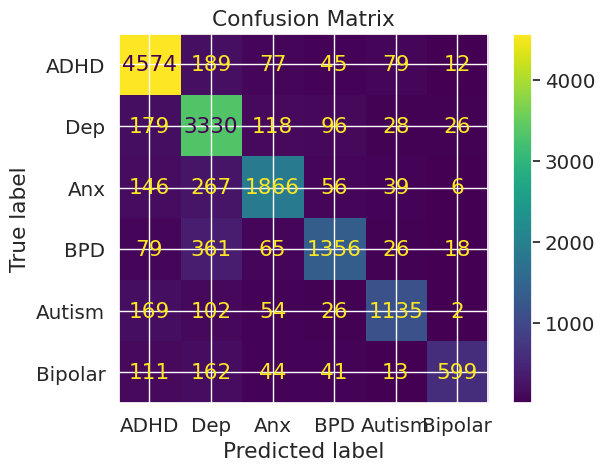

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      4976
           1       0.75      0.88      0.81      3777
           2       0.84      0.78      0.81      2380
           3       0.84      0.71      0.77      1905
           4       0.86      0.76      0.81      1488
           5       0.90      0.62      0.73       970

    accuracy                           0.83     15496
   macro avg       0.84      0.78      0.80     15496
weighted avg       0.83      0.83      0.83     15496



In [ ]:
#Train the model with the training data

# Initialize and train the Logistic Regression model
LR = LogisticRegression(solver='liblinear', random_state=0)
LR.fit(X_train, y_train)


#test the model with the test data
y_pred = LR.predict(X_test)

#calculate the accuracy
LR_accuracy = accuracy_score(y_test, y_pred)
LR_f1score = f1_score(y_test, y_pred, average='weighted')
LR_precision = precision_score(y_test, y_pred, average='weighted')
LR_recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy: ', LR_accuracy)
print('Precision: ', LR_precision)
print('Recall: ', LR_recall)
print('F1-Score: ', LR_f1score)

class_labels = ['ADHD', 'Dep', 'Anx', 'BPD', 'Autism', 'Bipolar']

# Calculate confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 16))
# Plot the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot()
plt.title("Confusion Matrix")
plt.show()

#calculate the F1 score
f1_Score = get_F1(LR, X_test, y_test)
pd.DataFrame(f1_Score, index=df.subreddit.unique(), columns=['F1 score'])

#Classification Report
print(classification_report(y_test, y_pred))

**Training the Random Forest model on the Training set**

Accuracy:  0.7422560660815695
Precision:  0.7824642386211487
Recall:  0.7422560660815695
F1-Score:  0.7286551354262644


<Figure size 2000x1600 with 0 Axes>

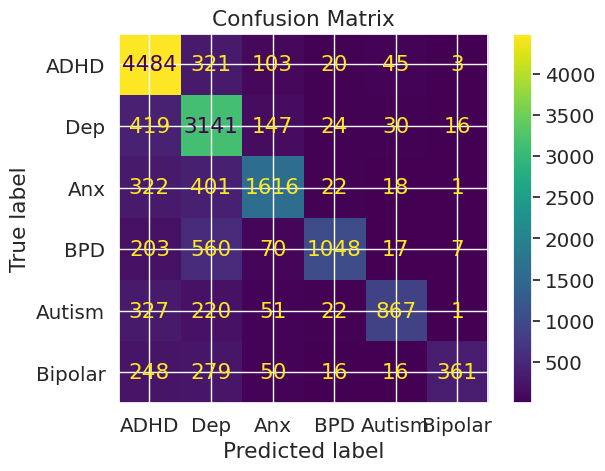

              precision    recall  f1-score   support

           0       0.75      0.90      0.82      4976
           1       0.64      0.83      0.72      3777
           2       0.79      0.68      0.73      2380
           3       0.91      0.55      0.69      1905
           4       0.87      0.58      0.70      1488
           5       0.93      0.37      0.53       970

    accuracy                           0.74     15496
   macro avg       0.81      0.65      0.70     15496
weighted avg       0.77      0.74      0.74     15496

              precision    recall  f1-score   support

           0       0.75      0.90      0.82      4976
           1       0.64      0.83      0.72      3777
           2       0.79      0.68      0.73      2380
           3       0.91      0.55      0.69      1905
           4       0.87      0.58      0.70      1488
           5       0.93      0.37      0.53       970

    accuracy                           0.74     15496
   macro avg       0.81

In [ ]:
#Train the model with the training data: Random Forest

RF = RandomForestClassifier(random_state = 0)
RF.fit(X_train, y_train)

#test the model with the test data
y_pred=RF.predict(X_test)

#calculate the accuracy
print('Accuracy: ', RF_accuracy)
print('Precision: ', RF_precision)
print('Recall: ', RF_recall)
print('F1-Score: ', RF_f1score)

class_labels = ['ADHD', 'Dep', 'Anx', 'BPD', 'Autism', 'Bipolar']

# Calculate confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 16))
# Plot the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot()
plt.title("Confusion Matrix")
plt.show()

#calculate the F1 score
f1_Score = get_F1(RF, X_test, y_test)
pd.DataFrame(f1_Score, index=df.subreddit.unique(), columns=['F1 score'])

#Classification Report
print(classification_report(y_test, y_pred))

**Training the Support Vector Machine model on the Training set**


In [ ]:
#Train the model with the training data
SVM = SVC(random_state = 0)
SVM.fit(X_train, y_train)

#test the model with the test data
y_pred=SVM.predict(X_test)

#calculate the accuracy
#calculate the accuracy
SVM_accuracy = accuracy_score(y_test, y_pred)
SVM_f1score = f1_score(y_test, y_pred, average='weighted')
SVM_precision = precision_score(y_test, y_pred, average='weighted')
SVM_recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy: ', SVM_accuracy)
print('Precision: ', SVM_precision)
print('Recall: ', SVM_recall)
print('F1-Score: ', SVM_f1score)

class_labels = ['ADHD', 'Dep', 'Anx', 'BPD', 'Autism', 'Bipolar']

# Calculate confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 16))
# Plot the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot()
plt.title("Confusion Matrix")
plt.show()

#calculate the F1 score
f1_Score = get_F1(SVM, X_test, y_test)
pd.DataFrame(f1_Score, index=df.subreddit.unique(), columns=['F1 score'])

#Classification Report
print(classification_report(y_test, y_pred))

Accuracy:  0.8202116675271037 

              precision    recall  f1-score   support

        ADHD       0.86      0.91      0.88      4976
     Anxiety       0.84      0.78      0.81      2380
      Autism       0.85      0.76      0.80      1488
         BPD       0.84      0.68      0.75      1905
     Bipolar       0.88      0.60      0.71       970
  Depression       0.74      0.88      0.81      3777

    accuracy                           0.82     15496
   macro avg       0.84      0.77      0.79     15496
weighted avg       0.83      0.82      0.82     15496



**Results - Text and Emotion Score Features**

In [ ]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machine','Random Forest'],
    'Accuracy': [LR_accuracy.round(2), SVM_accuracy.round(2), RF_accuracy.round(2)]})

models.sort_values(by='Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

Model  Accuracy
0     Logistic Regression      0.84
1  Support Vector Machine      0.82
2           Random Forest      0.74

## **References**

https://www.kaggle.com/code/anubhavgoyal10/spam-classifier-nlp-98-accuracy

https://www.kaggle.com/code/maeshi/text-classification-with-neural-networks

https://www.kaggle.com/code/mohamedabdelmohsen/emotion-analysis-and-classification-using-lstm-93
